In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')
import zipfile
import os
from tensorflow.keras.preprocessing.image import img_to_array, load_img, ImageDataGenerator
import numpy as np

path = '/tmp/expir/'
src_path = path + 'lfw'


In [ ]:
def empty_dir(dir_path):
  '''
  This function is deleting all files in directory `dit_path`
  :param: dir_path: the directory path to delete
  '''
  import os, shutil
  folder = dir_path
  if os.path.exists(dir_path):
    for filename in os.listdir(folder):
        file_path = os.path.join(folder, filename)
        try:
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.unlink(file_path)
            elif os.path.isdir(file_path):
                shutil.rmtree(file_path)
        except Exception as e:
            print('Failed to delete %s. Reason: %s' % (file_path, e))

In [ ]:
def clean_runtime():
  '''
  This Function is cleaning the runtime, so it can start from fresh setup
  '''
  # for dir in all_dirs_to_be_existed:
  #   empty_dir(dir)
  empty_dir(path)
  

clean_runtime()

In [ ]:
# download all data + train/test sets details txt 
!wget http://vis-www.cs.umass.edu/lfw/lfw.tgz -P $path
fullpath = path + 'lfw.tgz'
!tar zxvf $fullpath -C $path
!wget http://vis-www.cs.umass.edu/lfw/pairsDevTrain.txt -P $path
!wget http://vis-www.cs.umass.edu/lfw/pairsDevTest.txt -P $path

Streaming output truncated to the last 5000 lines.
lfw/Jose_Viegas_Filho/Jose_Viegas_Filho_0001.jpg
lfw/Jose_Viegas_Filho/Jose_Viegas_Filho_0002.jpg
lfw/Roger_Mahony/
lfw/Roger_Mahony/Roger_Mahony_0001.jpg
lfw/Clay_Aiken/
lfw/Clay_Aiken/Clay_Aiken_0001.jpg
lfw/Clay_Aiken/Clay_Aiken_0002.jpg
lfw/Clay_Aiken/Clay_Aiken_0003.jpg
lfw/Clay_Aiken/Clay_Aiken_0004.jpg
lfw/Clay_Aiken/Clay_Aiken_0005.jpg
lfw/Clay_Aiken/Clay_Aiken_0006.jpg
lfw/Edward_Egan/
lfw/Edward_Egan/Edward_Egan_0001.jpg
lfw/Pat_DAmuro/
lfw/Pat_DAmuro/Pat_DAmuro_0001.jpg
lfw/Demi_Moore/
lfw/Demi_Moore/Demi_Moore_0001.jpg
lfw/Demi_Moore/Demi_Moore_0002.jpg
lfw/Demi_Moore/Demi_Moore_0003.jpg
lfw/Demi_Moore/Demi_Moore_0004.jpg
lfw/Jamie_King/
lfw/Jamie_King/Jamie_King_0001.jpg
lfw/Joseph_Galante/
lfw/Joseph_Galante/Joseph_Galante_0001.jpg
lfw/Kenneth_Brill/
lfw/Kenneth_Brill/Kenneth_Brill_0001.jpg
lfw/Noel_Forgeard/
lfw/Noel_Forgeard/Noel_Forgeard_0001.jpg
lfw/Akbar_Al_Baker/
lfw/Akbar_Al_Baker/Akbar_Al_Baker_0001.jpg
lfw/Gregg_

# parsing the sets configurations


In [ ]:
def creating_array_of_pic_nums(file_lines, start_index, end_index, is_mismatch = False):
  '''
  This funciton is creating the array of pairs of samples names from the give `file_lines` list
  '''
  all_pics_names = []
  created_pic_pairs = []
  for index in range(start_index, end_index):
    line = str(file_lines[index]).replace('\n', '')
    line_split = line.split('\t')
    pic_num1 = str(line_split[1]).zfill(4)
    image_name1 = str(line_split[0])
    if not is_mismatch:
      pic_num2 = str(line_split[2]).zfill(4)
      image_name2 = image_name1
    else:
      image_name2 = str(line_split[2])
      pic_num2 = str(line_split[3]).zfill(4)

    created_pic_pairs.append((image_name1 + '_' + pic_num1, image_name2 + '_' + pic_num2))
    
    all_pics_names.append(image_name1 + '_' + pic_num1)
    all_pics_names.append(image_name2 + '_' + pic_num2)

  return created_pic_pairs, all_pics_names


def parse_txt_file(path):
  '''
  This function is parsing the txt file `path` and returns relevant arrays to our data
  '''
  pics_pairs_array = []
  all_images_names = []
  y_pairs_array = []
  with open(path, 'r') as samples_names:
    all_file_lines = samples_names.readlines()
    num_of_lines = all_file_lines[0]
    positive_pairs, positive_images_names = creating_array_of_pic_nums(all_file_lines, 1, int(num_of_lines) + 1)
    y_positive_pairs = [1 for pair in positive_pairs]
    mismatch_pairs, mismatch_images_names = creating_array_of_pic_nums(all_file_lines, int(num_of_lines) + 1, int(num_of_lines) * 2 + 1, True)
    y_mismatch_pairs = [0 for pair in mismatch_pairs]

    pics_pairs_array.extend(positive_pairs)
    y_pairs_array.extend(y_positive_pairs)
    pics_pairs_array.extend(mismatch_pairs)
    y_pairs_array.extend(y_mismatch_pairs)

    all_images_names.extend(positive_images_names)
    all_images_names.extend(mismatch_images_names)
    return pics_pairs_array, y_pairs_array, positive_pairs, y_positive_pairs, mismatch_pairs, y_mismatch_pairs, all_images_names

#parsing the txt files and generating sets lists
x_train_pics_pairs, y_train, train_positive, y_train_positive, train_mismatch, y_train_mismatch, train_images_names = parse_txt_file(path + 'pairsDevTrain.txt')
x_test_pics_pairs, y_test, test_positive, y_test_positive, test_mismatch, y_test_mismatch, test_images_names = parse_txt_file(path + 'pairsDevTest.txt')

txt_images_names = []
txt_images_names.extend(train_images_names)
txt_images_names.extend(test_images_names)
txt_images_names = set(txt_images_names)

# loading data and preprocessing

In [ ]:
def basic_preprocess(image):
    """
    preprocess a given image for the DCGAN256 model.
    :param image: PIL Image - the original image
    :return: ndarray - the image after preprocess
    """
    # image = np.array(image.convert('RGB'), dtype='float32')
    # image = image / 255
    return image


def load_image_from_file(img_path, target_size, preprocess):
  """
  Load  an image from the given img_path.
  :param img_path: String - a path to an image
  :param target_size: tuple - the dimensions of the image that will be loaded
  :param preprocess: function - a pre-processing function
  :return: image
  """
  # load the input image using the Keras helper utility while ensuring
  # the image is resized to `image_shape`
  image = load_img(img_path, target_size=target_size)

  image = img_to_array(image)
  # our input image is now represented as a NumPy array of shape
  # (inputShape[0], inputShape[1], 3) however we need to expand the
  # dimension by making the shape (1, inputShape[0], inputShape[1], 3)
  # so we can pass it through the network
  image = np.expand_dims(image, axis=0)
  image = preprocess(image)

  return image

def load_images_from_path(img_folder_path, target_size, images_to_load, preprocess):
  """
  Loads and preprocess images from a given folder path.
  returns a list of the images and a list of their names.
  :param target_size: tuple - the dimensions of the image that will be loaded
  :param preprocess: function - a pre-processing function
  :param img_folder_path: String - a path to a folder that contains images.
  :param images_to_load: list - a list of the images names to load.
  :return: images, images_names - list - lists of the images and the images names
  """
  images = []
  images_names = []
  counter = 0
  for inner_folder_path in os.listdir(img_folder_path):
    full_inner_folder_path=os.path.join(img_folder_path, inner_folder_path)
    for img_path in os.listdir(full_inner_folder_path):  # load all images into a list
      if img_path.replace(".jpg","") in images_to_load:
        counter = counter+1
        print(str(counter)+" "+img_path)
        full_img_path = os.path.join(full_inner_folder_path, img_path)
        img = load_image_from_file(full_img_path, target_size, preprocess)
        # appending
        images_names.append(img_path.replace(".jpg",""))
        images.append(img)
  return np.vstack(images), images_names



target_size = (105,105)

images, images_names = load_images_from_path(src_path, target_size, txt_images_names,basic_preprocess)


def set_from_names(names_pairs_in_set, samples, samples_names):
  '''
  This function get the names of the pairs and returns list of the actual samples (images)
  '''
  first_samples_in_set = []
  second_samples_in_set = []
  for pair in names_pairs_in_set:
    first_sample_name = pair[0]
    first_sample_index = samples_names.index(first_sample_name)
    first_sample = samples[first_sample_index]    
    
    second_sample_name = pair[1]
    second_sample_index = samples_names.index(second_sample_name)
    second_sample = samples[second_sample_index] 

    first_samples_in_set.append(first_sample)
    second_samples_in_set.append(second_sample)
  return first_samples_in_set, second_samples_in_set

X_train_a, X_train_b = set_from_names(names_pairs_in_set=x_train_pics_pairs, samples=images, samples_names=images_names)
X_test_a, X_test_b = set_from_names(names_pairs_in_set=x_test_pics_pairs, samples=images, samples_names=images_names)


1 Yann_Martel_0002.jpg
2 Yann_Martel_0001.jpg
3 Luis_Horna_0005.jpg
4 Luis_Horna_0003.jpg
5 Luis_Horna_0002.jpg
6 Luis_Horna_0001.jpg
7 John_Thune_0001.jpg
8 Silvan_Shalom_0006.jpg
9 Silvan_Shalom_0001.jpg
10 Recep_Tayyip_Erdogan_0008.jpg
11 Recep_Tayyip_Erdogan_0004.jpg
12 Recep_Tayyip_Erdogan_0029.jpg
13 Recep_Tayyip_Erdogan_0014.jpg
14 Recep_Tayyip_Erdogan_0002.jpg
15 Lene_Espersen_0001.jpg
16 Dorothy_Lamour_0001.jpg
17 Jose_Bove_0001.jpg
18 Aram_Adler_0001.jpg
19 Harvey_Fierstein_0001.jpg
20 Kirk_Johnson_0001.jpg
21 Mohammed_Ashraf_Hafiz_0001.jpg
22 Cathy_Freeman_0002.jpg
23 Cathy_Freeman_0001.jpg
24 Deb_Santos_0001.jpg
25 Jonathan_Mostow_0001.jpg
26 Jonathan_Mostow_0002.jpg
27 Larry_Lucchino_0001.jpg
28 Larry_Lucchino_0002.jpg
29 Roger_Federer_0008.jpg
30 Roger_Federer_0003.jpg
31 Roger_Federer_0012.jpg
32 Roger_Federer_0004.jpg
33 Juliette_Binoche_0001.jpg
34 Vanessa_Laine_0001.jpg
35 Donald_Hays_0001.jpg
36 Elena_Bereznaya_0001.jpg
37 Jen_Schefft_0001.jpg
38 Andrew_Fastow_0001.j

In [ ]:
# transform the sets to numpy arrays
X_train_a = np.array(X_train_a)
X_train_b = np.array(X_train_b)
X_test_a = np.array(X_test_a)
X_test_b = np.array(X_test_b)
y_train = np.array(y_train)
y_test = np.array(y_test)


# Siamese Convolutional Network

In [ ]:
from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten,MaxPooling2D, Subtract, BatchNormalization, Activation, Dropout
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam#, SGD, RMSprop
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.utils import plot_model
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.metrics import BinaryAccuracy
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import KFold
from tensorflow.keras import backend as K

import json
import timeit



# preperation for training and further preprocessing

In [ ]:
# patience=20 is the early stopping criteria. 
# It dictates how many epochs to keep train the model if there is not a improvmant 
early_stopping  = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=20)

# Pre processing and data augmentation
data_generator_train = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    rescale=1. / 255,
    shear_range=0.1,
    zoom_range=0.1,
)
data_generator_test = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rescale=1. / 255,
)
# compute quantities required for featurewise normalization
# std, mean
data_generator_train.fit(X_train_a)
data_generator_train.fit(X_train_b)
data_generator_test.fit(X_train_a)
data_generator_test.fit(X_train_b)

# standardize test set
X_test_a = data_generator_test.standardize(X_test_a)
X_test_b = data_generator_test.standardize(X_test_b)



# Building a sequential model

In [ ]:

def siamese_network_model(layers, input_shape, optimizer):
  """
  Build siamese convolutional network and complie and return it
  """
  input_a = Input(input_shape)
  input_b = Input(input_shape)

  W_conv_init = RandomNormal(mean = 0.0, stddev = 1e-2)
  W_fc_init = RandomNormal(mean = 0.0, stddev = 2e-1)
  b_init = RandomNormal(mean = 0.5, stddev = 1e-2)

  feature_model = Sequential([
    Conv2D(64, (10,10), input_shape=input_shape, kernel_initializer=W_conv_init, bias_initializer=b_init, kernel_regularizer=l2(2e-4)),
    BatchNormalization(momentum=0.7),
    Activation('relu'),
    # Dropout(0.2),
    MaxPooling2D(2, 2),
    Conv2D(128, (7,7), kernel_initializer=W_conv_init, bias_initializer=b_init, kernel_regularizer=l2(2e-4)),
    BatchNormalization(momentum=0.7),
    Activation('relu'),
    # Dropout(0.2),
    MaxPooling2D(2,2),
    Conv2D(128, (4,4), kernel_initializer=W_conv_init, bias_initializer=b_init, kernel_regularizer=l2(2e-4)),
    BatchNormalization(momentum=0.7),
    Activation('relu'),
    # Dropout(0.2),
    MaxPooling2D(2,2),
    Conv2D(256, (4,4), kernel_initializer=W_conv_init, bias_initializer=b_init, kernel_regularizer=l2(2e-4)),
    BatchNormalization(momentum=0.7),
    Activation('relu'),
    Dropout(0.2),
    Flatten(),
    Dense(4096, activation='sigmoid', kernel_initializer=W_fc_init, bias_initializer=b_init)
  ])

  encoded_a = feature_model(input_a)
  encoded_b = feature_model(input_b)


  #distance calculation
  subtracted = Subtract()([encoded_a, encoded_b])
  out = Dense(1, activation='sigmoid', kernel_initializer=W_fc_init, bias_initializer=b_init)(subtracted)

  siamese_net_model = Model(inputs=[input_a, input_b], outputs=out)

  siamese_net_model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=["accuracy"])

  feature_model.compile(loss="binary_crossentropy",optimizer=optimizer)
  
  return siamese_net_model


# Training the model


In [ ]:
def aug_images(x_a, x_b, y, rounds=1):
  """
  Function to create augmented images 
  """
  augmented_a = []
  augmented_b = []
  augmented_y = []
  for r in range(rounds):
      # Increase the dataset `rounds` times, with augmented images
      # each image will be present rounds times each augmented differently
      x_a_aug = data_generator_train.flow(x_a, batch_size=1, shuffle=False, seed=r)
      x_b_aug = data_generator_train.flow(x_b, batch_size=1, shuffle=False, seed=r)
      for pair_indexes in range(len(x_a)):
          augmented_a.append(x_a_aug.next())
          augmented_b.append(x_b_aug.next())
          augmented_y.append(y[pair_indexes])

  augmented_a = np.vstack(augmented_a)
  augmented_b = np.vstack(augmented_b)
  augmented_y = np.vstack(augmented_y)
  return augmented_a, augmented_b, augmented_y

In [ ]:

parameters = {'epochs': [10,20,40], 
              'batch_size': [8,16,32],
              'learning_rate': [0.0001, 0.001, 0.01],
              # 'input_shape': [(105, 105, 3)],
              'rounds': [1,2,3], # 1 only tranforms the data without expanding the number of samples
              'optimizer': [Adam]
             }

def cv_score(parameters, x_a, x_b, y):
  '''
  This function is running the Cross Validation testing on the network
  using the given parameters
  '''

  print("cv_score")
  kf = KFold(n_splits=5, shuffle=True)
  print("kfold")

  acc_scores = []
  loss_scores = []
  fit_times = []
  m = BinaryAccuracy()
  bce = BinaryCrossentropy()

  fold_counter = 0
  for train_index, val_index in kf.split(x_a):
      print('Fold', fold_counter)
      fold_counter += 1
      model = siamese_network_model(None, x_a[0].shape, parameters["opt"](parameters["lr"]))
      x_train_a_cv, x_train_b_cv, = x_a[train_index], x_b[train_index]
      x_val_a_cv, x_val_b_cv = x_a[val_index], x_b[val_index]
      y_train_cv, y_val_cv = y[train_index], y[val_index]
      x_val_a_cv = data_generator_train.standardize(x_val_a_cv)
      x_val_b_cv = data_generator_train.standardize(x_val_b_cv)
      val_data = [x_val_a_cv, x_val_b_cv]

      x_train_a_cv_aug, x_train_b_cv_aug, y_train_cv_aug = aug_images(x_train_a_cv, x_train_b_cv, y_train_cv, rounds=parameters['rnd'])
      train_data = [x_train_a_cv_aug, x_train_b_cv_aug]

      # Training the algorithm using the predictors and target.
      fit_start_time = timeit.default_timer()
      model.fit(
          train_data,
          y_train_cv_aug,
          epochs=parameters['epoch'],
          batch_size=parameters['batch'],
          validation_data=(val_data, y_val_cv),
          verbose=1,
          callbacks=[early_stopping]
      )
      fit_end_time = timeit.default_timer()
      fit_time = fit_end_time - fit_start_time

      fit_times.append(fit_time)
      # Record accuracy from each cross-validation run
      predicts = model.predict([x_val_a_cv, x_val_b_cv], verbose=0)
      m.reset_states()
      m.update_state(y_val_cv, predicts)

      loss_score = bce(y_val_cv, predicts).numpy()
      loss_scores.append(loss_score)

      acc_score = m.result().numpy()
      acc_scores.append(acc_score)

      K.clear_session()

  mean_acc_cv_score = np.mean(acc_scores)
  mean_loss_cv_score = np.mean(loss_scores)
  mean_fit_time_cv_score = np.mean(fit_times)
  print(f"Cross-Validation acc_score {mean_acc_cv_score}")
  return mean_acc_cv_score, mean_loss_cv_score, mean_fit_time_cv_score

def grid_search(grid_params):
  '''
  This function is running the grid_search for the model parameters
  and returns a dictionary containing the best parameters
  '''
  DL_max_acc = 0
  DL_mean_convergance_time = 0
  DL_loss = 0
  DL_best_params = []
  grid_search_results = []
  count_runs = 0
  for epoch in grid_params['epochs']:
    for batch in grid_params['batch_size']:
      for lr in grid_params['learning_rate']:
        for rnd in grid_params['rounds']:
          for opt in grid_params['optimizer']:
            params = {"epoch":epoch, "batch":batch, "lr":lr, "rnd":rnd, "opt":opt}
            print(params)
            mean_acc, mean_loss, mean_convergance_time = cv_score(params, X_train_a, X_train_b, y_train)
            
            # converting optimizer to its name
            if params['opt'] is Adam:
              params['opt'] = 'Adam'
            elif params['opt'] is RMSprop:
              params['opt'] = 'RMSprop'
            else:
              params['opt'] = 'could not identifiy optimizer'

            current_params = {
                    "params": params,
                    "mean_acc": str(mean_acc),
                    "mean_loss": str(mean_loss),
                    "mean_convergance_time": str(mean_convergance_time)
                 }
            
            grid_search_results.append(current_params)
            # Pretty print the results
            json.dumps(current_params, indent=4)

            count_runs += 1
            print('---')
            if mean_acc > DL_max_acc:
              DL_best_params = params
              DL_max_acc = mean_acc
              DL_mean_convergance_time = mean_convergance_time
              DL_loss = mean_loss

  return DL_max_acc, DL_best_params, grid_search_results,DL_mean_convergance_time, DL_loss

max_acc, best_params, grid_results, best_mean_converagnce_time, best_loss = grid_search(parameters)


 

In [ ]:
print(f"DL_max_acc: {max_acc}") 
print(f"best_params: {best_params}")  
print(f"best loss: {best_loss}")    
print(f"best mean convergance time: {best_mean_converagnce_time}")
for result in grid_results:
  print(str(result), '=', str(grid_results[result]))  
  print('-------------------------')

## Training the model with the best params

In [ ]:
# We found that the following params are the best params 
best_params= {'epoch': 40, 'batch': 32, 'lr': 0.00005, 'rnd': 3, 'opt': Adam}
best_params

{'batch': 32,
 'epoch': 40,
 'lr': 5e-05,
 'opt': tensorflow.python.keras.optimizer_v2.adam.Adam,
 'rnd': 3}

In [ ]:
# Validate the optimizer is not text (we changed it during the testing of this notebook)
if best_params['opt'] is 'Adam':
  best_params['opt'] = Adam

# Last training of the model before prediction  
model = siamese_network_model(None, X_train_a[0].shape, best_params["opt"](best_params["lr"]))


test_data = [X_test_a, X_test_b]

x_train_a_aug, x_train_b_aug, y_train_aug = aug_images(X_train_a, X_train_b, y_train, rounds=best_params['rnd'])
train_data = [x_train_a_aug, x_train_b_aug]

# Training the algorithm using the predictors and target.
fit_start_time = timeit.default_timer()
history = model.fit(
  train_data,
  y_train_aug,
  epochs=best_params['epoch'],
  batch_size=best_params['batch'],
  validation_data=(test_data, y_test),
  verbose=1,                   
  callbacks=[early_stopping]
)
fit_end_time = timeit.default_timer()
fit_time = fit_end_time - fit_start_time




Epoch 1/40
207/207 [==============================] - 22s 99ms/step - loss: 2.9218 - accuracy: 0.4982 - val_loss: 2.7758 - val_accuracy: 0.4960
Epoch 2/40
207/207 [==============================] - 20s 98ms/step - loss: 2.3533 - accuracy: 0.5469 - val_loss: 2.4416 - val_accuracy: 0.5130
Epoch 3/40
207/207 [==============================] - 21s 99ms/step - loss: 2.1592 - accuracy: 0.5627 - val_loss: 2.1436 - val_accuracy: 0.4860
Epoch 4/40
207/207 [==============================] - 20s 98ms/step - loss: 2.0132 - accuracy: 0.5589 - val_loss: 2.0397 - val_accuracy: 0.5090
Epoch 5/40
207/207 [==============================] - 20s 98ms/step - loss: 1.9522 - accuracy: 0.5685 - val_loss: 2.0977 - val_accuracy: 0.5130
Epoch 6/40
207/207 [==============================] - 20s 98ms/step - loss: 1.7856 - accuracy: 0.5923 - val_loss: 2.2096 - val_accuracy: 0.4960
Epoch 7/40
207/207 [==============================] - 20s 98ms/step - loss: 1.6698 - accuracy: 0.6061 - val_loss: 2.0616 - val_accuracy:

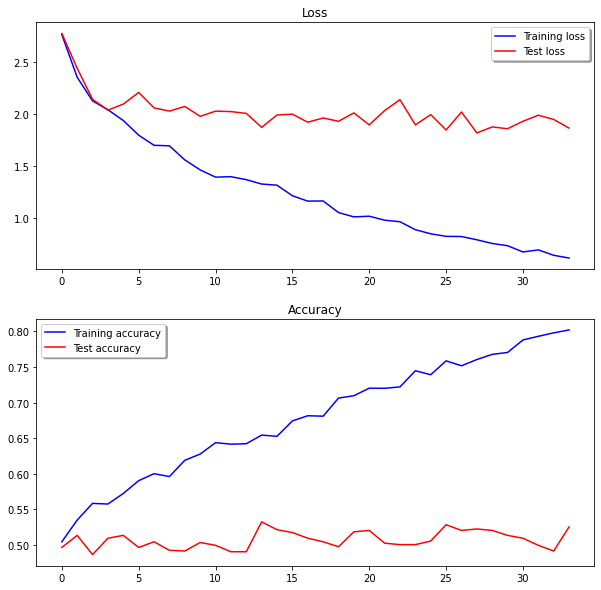

In [ ]:
from matplotlib import pyplot as plt
def plot_acc_loss_history(history):
  '''
  This funciton is getting history of training data
  and plots 2 graphs of training-test losses and accuracy correspondly
  '''
  fig, ax1 = plt.subplots(nrows=2, ncols=1, figsize=(10,10))
  ax1[0].plot(history.history['loss'], color='b', label="Training loss")
  ax1[0].plot(history.history['val_loss'], color='r', label="Test loss",axes =ax1[0])
  legend = ax1[0].legend(loc='best', shadow=True)
  ax1[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
  ax1[1].plot(history.history['val_accuracy'], color='r',label="Test accuracy")
  legend = ax1[1].legend(loc='best', shadow=True)
  ax1[0].set_title('Loss')
  ax1[1].set_title('Accuracy')

plot_acc_loss_history(history)

## Computing metrics and creating confusion matrix 




Convergance time = 691.7283449980005
loss = 2.0015767
accuracy = 0.525
              precision    recall  f1-score   support

           0       0.53      0.48      0.50       500
           1       0.52      0.57      0.55       500

    accuracy                           0.53      1000
   macro avg       0.53      0.52      0.52      1000
weighted avg       0.53      0.53      0.52      1000

TN = 239
FN = 214
TP = 286
FP = 261
ACC = 0.525
TPR = 0.572
TNR = 0.478
FPR = 0.522
FNR = 0.428
PPV = 0.5228519195612431
NPV = 0.5275938189845475


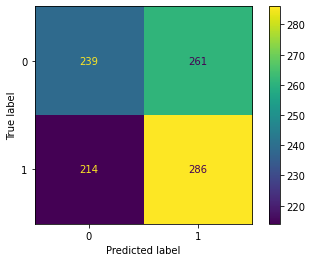

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
# using the trained model predict the test data
predicts = model.predict(test_data, verbose=0)

m = BinaryAccuracy()
m.reset_states()
m.update_state(y_test, predicts)
acc_score = m.result().numpy()

bce = BinaryCrossentropy()
loss_score = bce(y_train, predicts).numpy()

print("Convergance time =", fit_time)
print("loss =", loss_score)
print("accuracy =", acc_score)

DL_predicts = [0 if i<0.5 else 1 for i in predicts]
print(classification_report(y_test, DL_predicts))
DL_cf = confusion_matrix(y_test, DL_predicts)
ConfusionMatrixDisplay(DL_cf, display_labels=[0,1]).plot(values_format='d')

TN = DL_cf[0][0]
FN = DL_cf[1][0]
TP = DL_cf[1][1]
FP = DL_cf[0][1]



print("TN =",TN)
print("FN =", FN)
print("TP =",TP)
print("FP =",FP)

# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
# Specificity or true negative rate
TNR = TN/(TN+FP) 
# Precision or positive predictive value
PPV = TP/(TP+FP)
# Negative predictive value
NPV = TN/(TN+FN)
# Fall out or false positive rate
FPR = FP/(FP+TN)
# False negative rate
FNR = FN/(TP+FN)
# False discovery rate
FDR = FP/(TP+FP)

# Overall accuracy
ACC = (TP+TN)/(TP+FP+FN+TN)

print("ACC =", ACC)
print("TPR =", TPR)
print("TNR =", TNR)
print("FPR =", FPR)
print("FNR =", FNR)
print("PPV =", PPV)
print("NPV =", NPV)


# Error Analysis

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0 0 0 0 0 0 0 0 0 0]
[1, 0, 0, 1, 1, 1, 1, 0, 1, 1]
y_test[997] 0
DL_predicts[997] 0


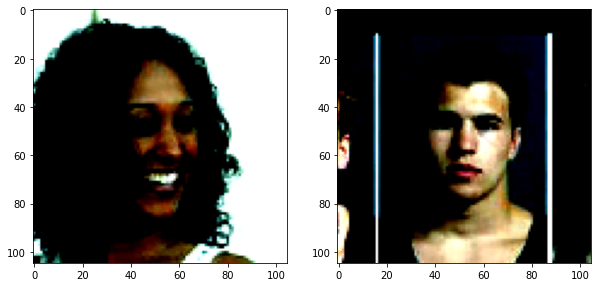

In [ ]:
# print(y_test[990:])
# print(DL_predicts[990:])
# plt.imshow(X_test_a[995])
# plt.imshow(X_test_b[995])

# Error analysis (view images)

 